In [ ]:
!pip install pytesseract
!pip install albumentations
!pip install pytorch_lightning
!pip install torchvision

In [1]:
import pytesseract
import os
import sys

sys.path.append("../")
from predict import Predict
from albumentations import Compose, Resize, Normalize
from albumentations.pytorch.transforms import ToTensorV2
from PIL import Image

In [10]:
import shutil, random
random.seed(10)
dirpath = 'X:\\HAB-tableaux-comptes-sociaux\\test_fp'

filenames = random.sample(os.listdir(dirpath), 10)
paths = []
for fname in filenames:
    srcpath = os.path.join(dirpath, fname)
    paths.append(srcpath)

In [208]:
image_path = paths[3]

In [5]:
pytesseract.pytesseract.tesseract_cmd = r'Y:\Logiciels\Tesseract\tesseract-ocr-v5.0.0.alpha\tesseract.exe'
os.environ["TORCH_HOME"] = 'X:\\HAB-tableaux-comptes-sociaux\\weights\\'

transforms = Compose([
    Resize(896, 896, always_apply=True),
    Normalize(),
    ToTensorV2()
])

model_weights = "X:\\HAB-tableaux-comptes-sociaux\\models\\modele Marmot.ckpt"
pred = Predict(model_weights, transforms)

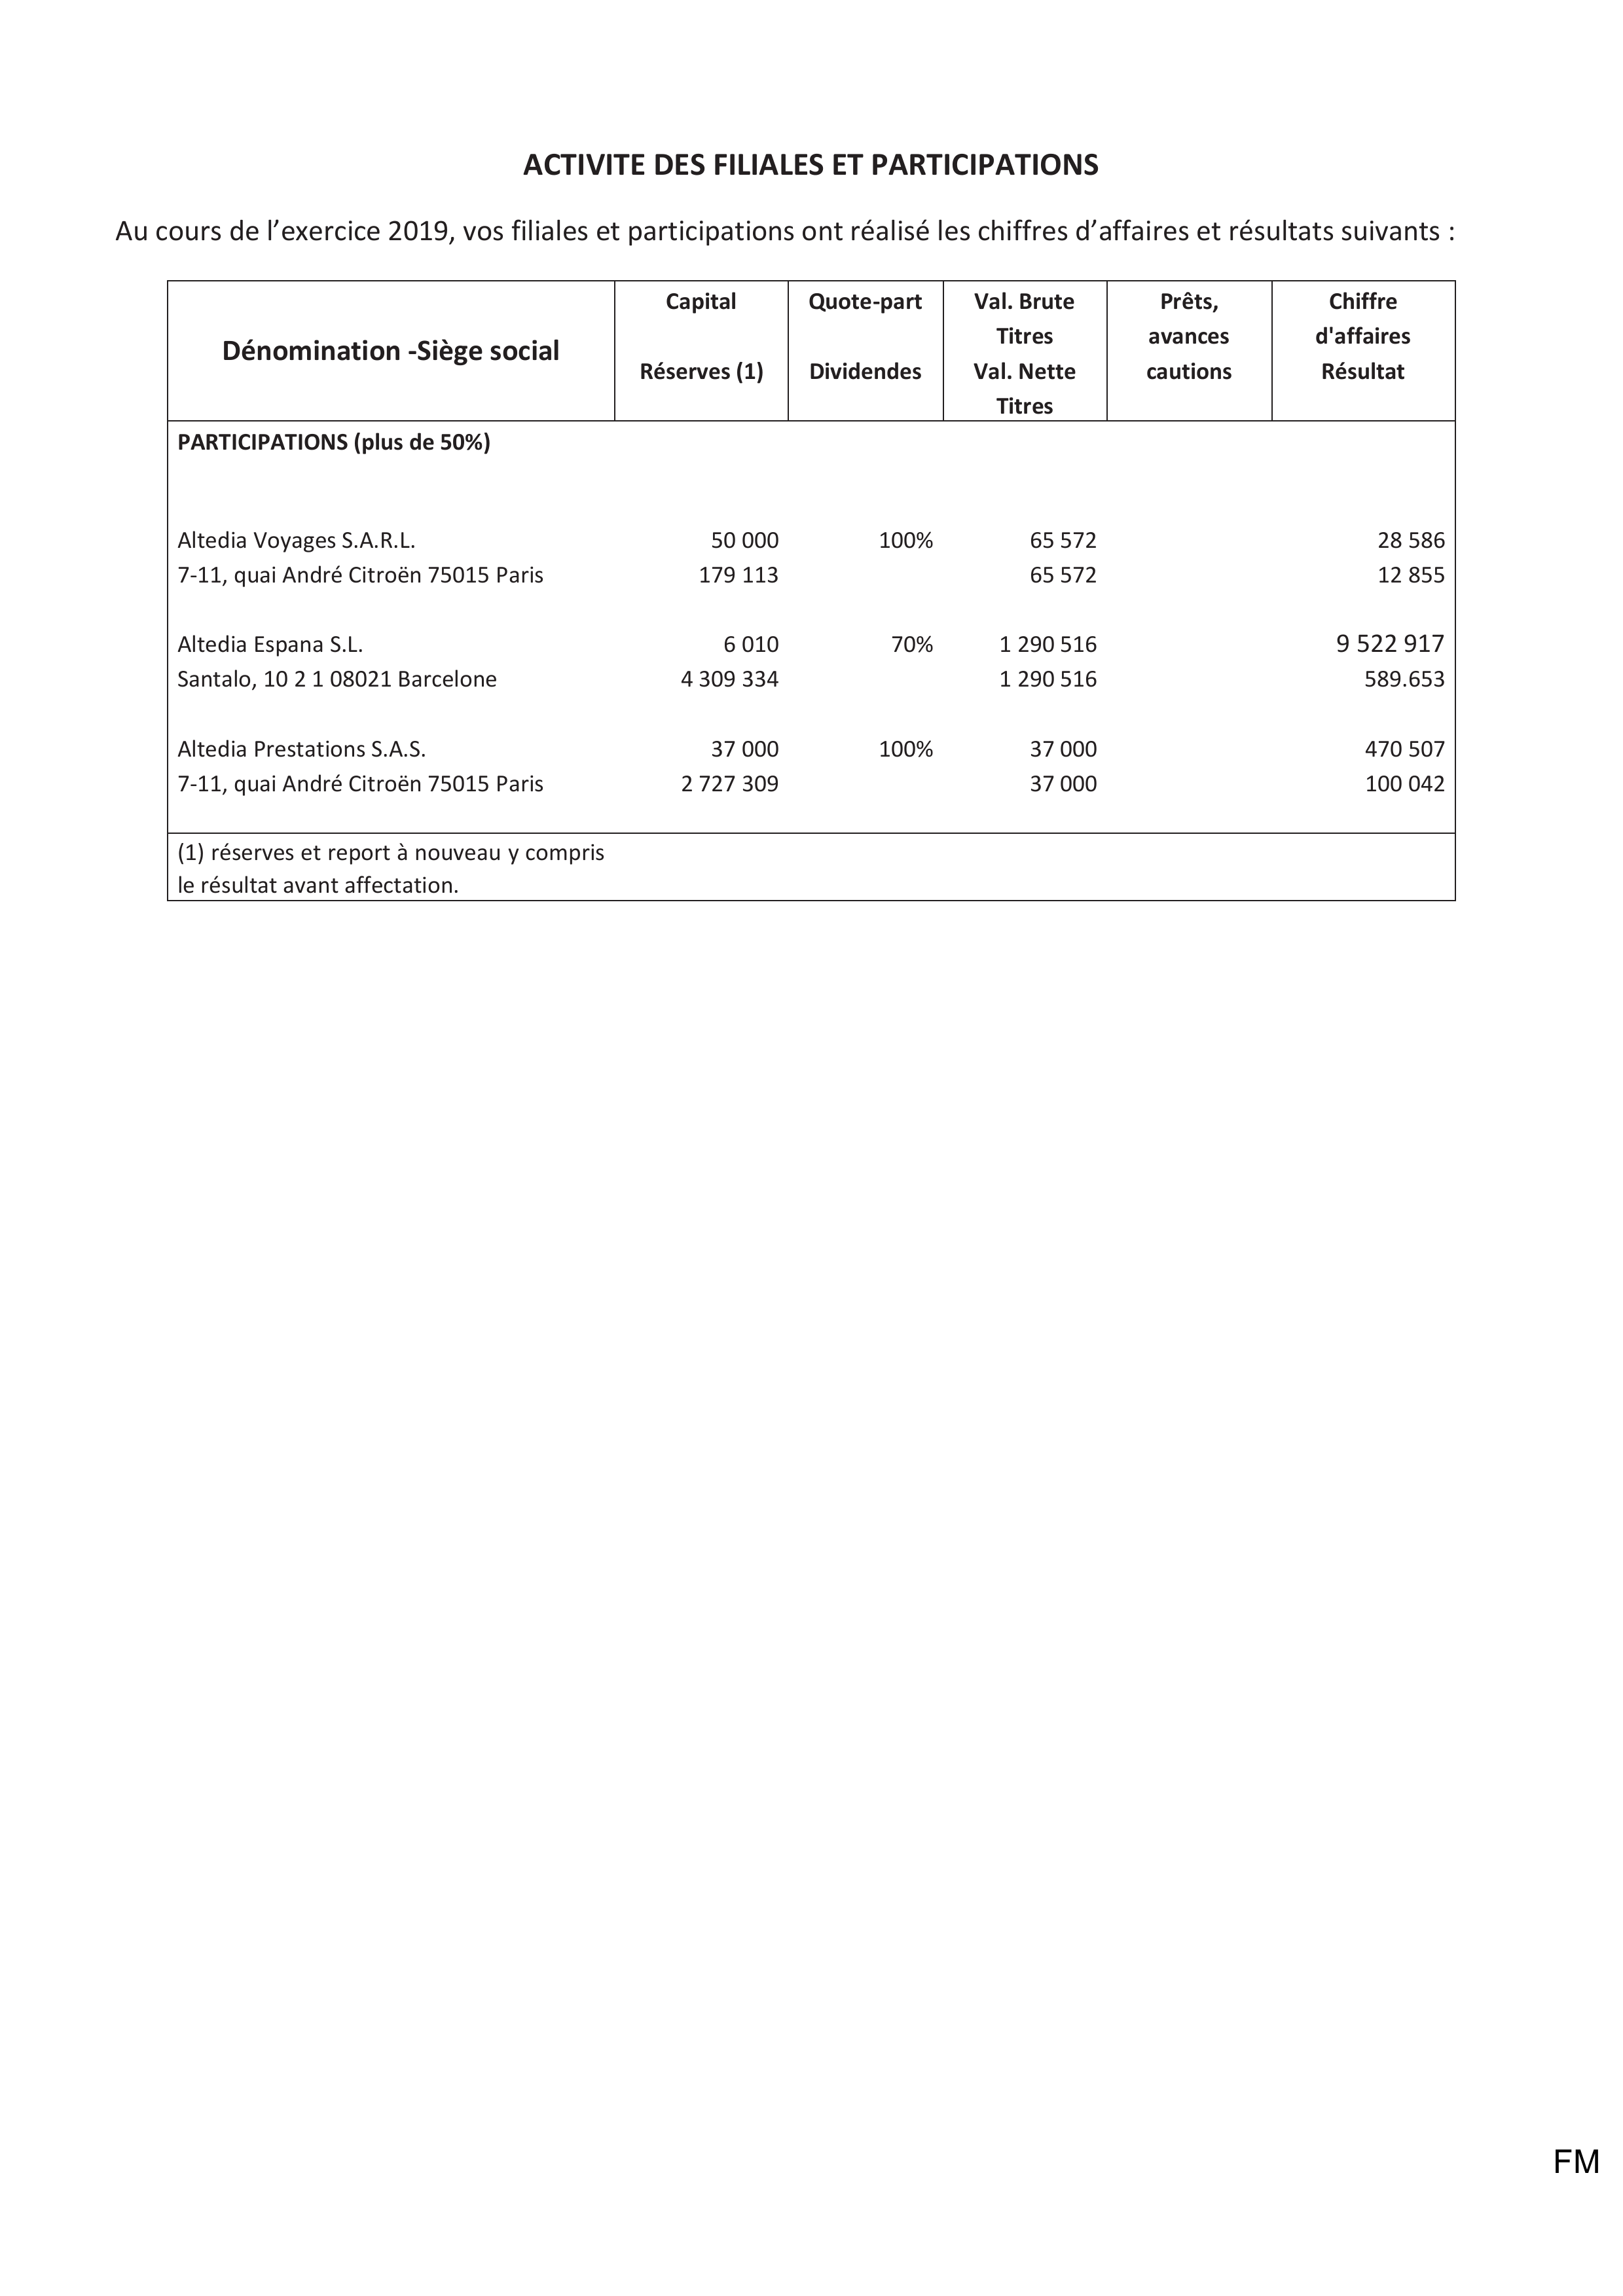

In [209]:
image = Image.open(image_path)
image

### Untilt image

In [252]:
def get_skew_angle(image) -> float:
    # Image preprocessing
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (9, 9), 0)
    thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (30, 5))
    dilate = cv2.dilate(thresh, kernel, iterations=5)

    # Find all contours
    contours, hierarchy = cv2.findContours(dilate, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key = cv2.contourArea, reverse = True)

    # Find largest contour and surround in min area box
    largest_contour = contours[0]
    
    # Get and return skew angle
    angle = cv2.minAreaRect(largest_contour)[-1]
    if angle < -45:
        angle = 90 + angle
    return -1.0 * angle

In [253]:
# Rotate the image around its center
def rotate_image(image, angle: float):
    new_image = image.copy()
    (h, w) = new_image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    new_image = cv2.warpAffine(new_image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    return new_image

# Deskew image
def deskew(image):
    image_array = np.array(image)
    angle = get_skew_angle(image_array)
    if np.abs(angle) < 3.0:
        return Image.fromarray(rotate_image(image_array, -1.0 * angle).astype('uint8'), 'RGB')
    return image

In [254]:
image = deskew(image)

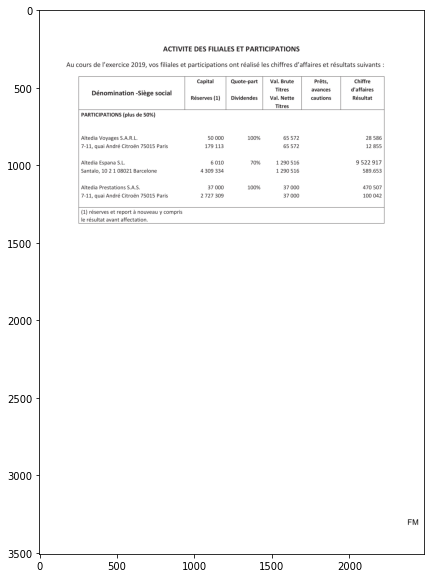

In [255]:
plt.plot()
plt.imshow(image)
plt.show()

### Create csv of first table

In [214]:
#test = pred.predict(Image.fromarray(corrected_image.astype('uint8'), 'RGB'))
test = pred.predict(image)

In [215]:
import numpy
unique, counts = numpy.unique(test['table_mask'], return_counts=True)
dict(zip(unique, counts))

{0: 659248, 1: 143568}

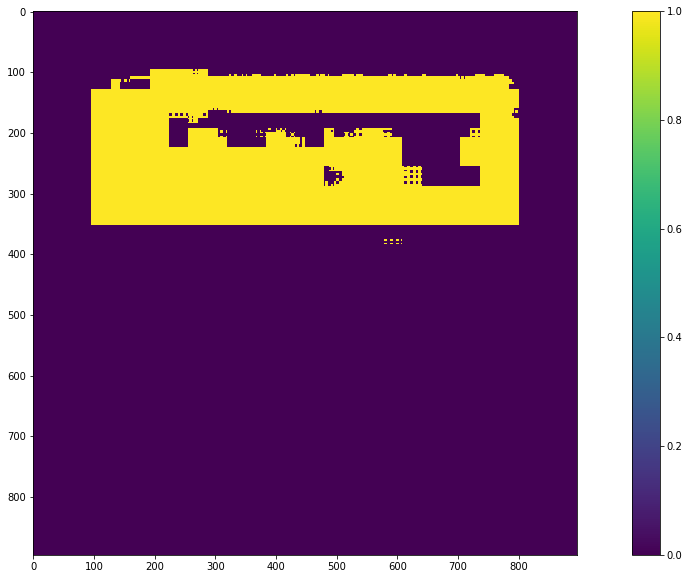

In [216]:
from matplotlib import pyplot as plt

plt.rcParams["figure.figsize"] = (20,10)
plt.plot()
plt.imshow(test['table_mask'], interpolation='none')
plt.colorbar(orientation='vertical')
plt.show()

Que fait la fonction `segment_image` ? Elle utilise des fonctions de la librairie `skimage` :
- `threshold_otsu` : crée une image binaire (0 et 1) à partir d'une greyscale image. Pas nécessaire ici en théorie parce que les masques sont déjà des images binaires ?
- `closing` : "Return grayscale morphological closing of an image. The morphological closing of an image is defined as a dilation followed by an erosion. Closing can remove small dark spots (i.e. “pepper”) and connect small bright cracks. This tends to “close” up (dark) gaps between (bright) features."
- `clear_border` : "Clear objects connected to the label image border."
- `label` : "Label connected regions of an integer array. Two pixels are connected when they are neighbors and have the same value. In 2D, they can be neighbors either in a 1- or 2-connected sense. The value refers to the maximum number of orthogonal hops to consider a pixel/voxel a neighbor. Returns a labeled array, where all connected regions are assigned the same integer value."

In [217]:
Predict.segment_image(test['table_mask']).sum()

146766

In [218]:
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import closing, square, convex_hull_image
from skimage.transform import resize
from skimage.util import invert

def segment_image(image):
    thresh = threshold_otsu(image)
    bw = closing(image > thresh, square(2))
    cleared = clear_border(bw)
    label_image = label(cleared)

    return label_image

In [219]:
thresh = threshold_otsu(test['table_mask'])

In [220]:
bw = closing(test['table_mask'] > thresh, square(2))

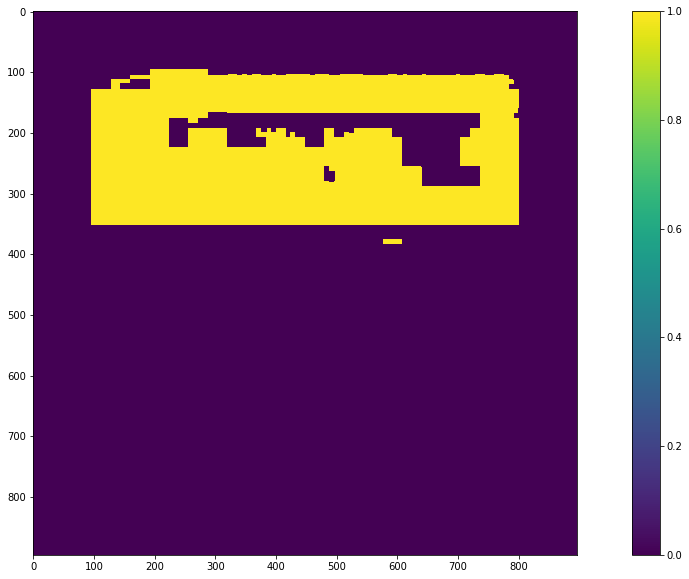

In [221]:
plt.plot()
plt.imshow(bw, interpolation='none')
plt.colorbar(orientation='vertical')
plt.show()

In [222]:
cleared = clear_border(bw)

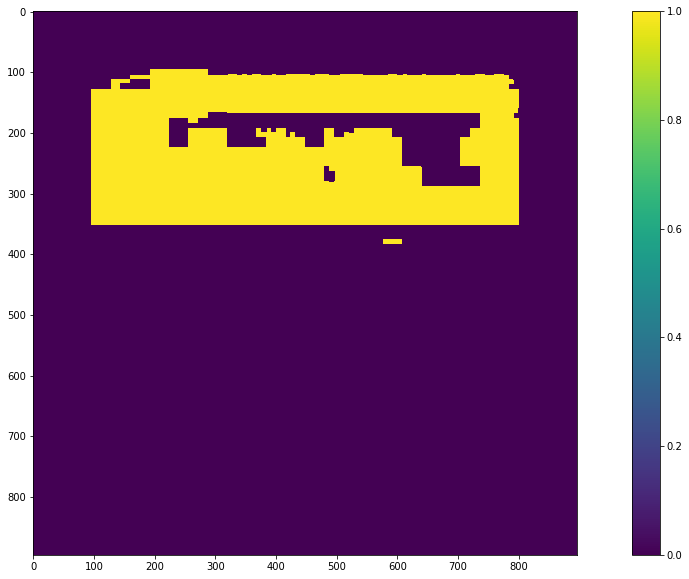

In [223]:
plt.plot()
plt.imshow(cleared, interpolation='none')
plt.colorbar(orientation='vertical')
plt.show()

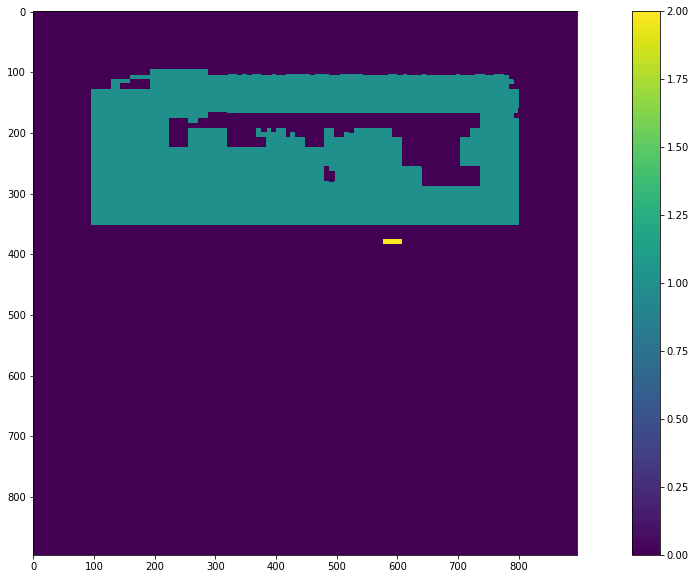

In [224]:
label_image = label(cleared)
plt.plot()
plt.imshow(label_image, interpolation='none')
plt.colorbar(orientation='vertical')
plt.show()

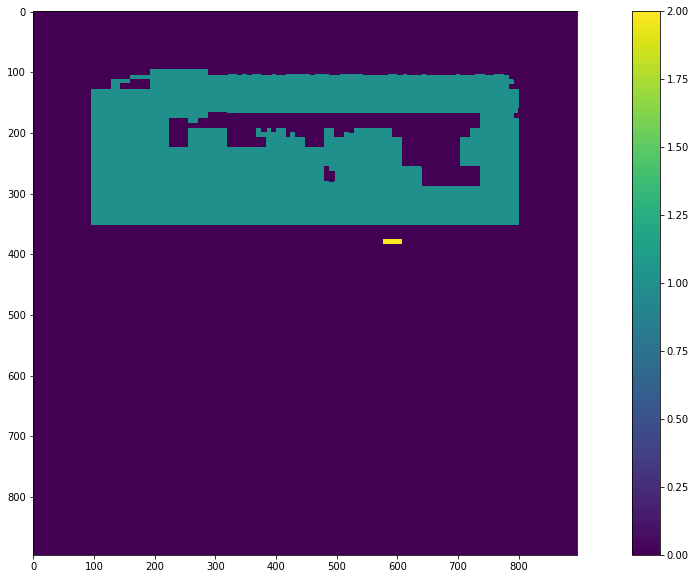

In [225]:
label_image = label(bw)
plt.plot()
plt.imshow(label_image, interpolation='none')
plt.colorbar(orientation='vertical')
plt.show()

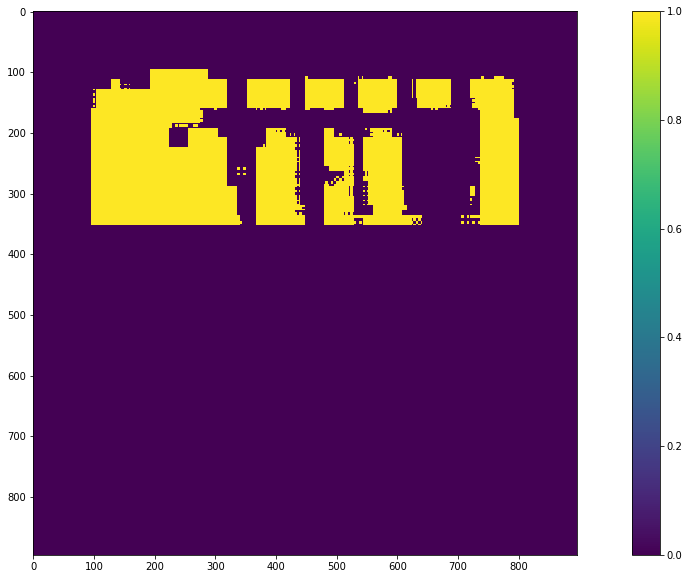

In [226]:
plt.plot()
plt.imshow(test['column_mask'], interpolation='none')
plt.colorbar(orientation='vertical')
plt.show()

In [227]:
import numpy as np
label_image.shape

(896, 896)

In [228]:
np.unique(label_image)[1:]

array([1, 2])

In [229]:
from skimage.morphology import closing, square, convex_hull_image
per = 0.005

width, height = label_image.shape
segmented_tables = []
for i in np.unique(label_image)[1:]:
    table = np.where(label_image == i, 1, 0)
    if table.sum() > height * width * per:
        segmented_tables.append(convex_hull_image(table))

In [230]:
len(segmented_tables)

1

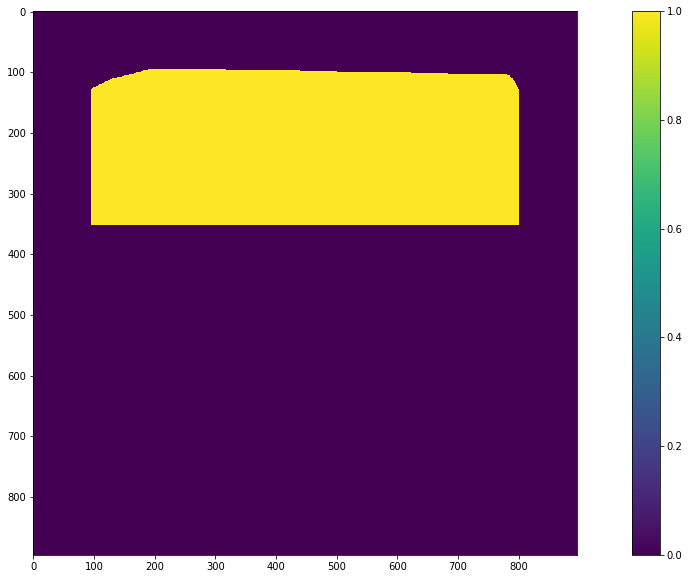

In [231]:
plt.plot()
plt.imshow(segmented_tables[0], interpolation='none')
plt.colorbar(orientation='vertical')
plt.show()

In [232]:
column_mask = test['column_mask']
column_image = column_mask * segmented_tables[0]

In [233]:
thresh = threshold_otsu(column_image)
bw = closing(column_image > thresh, square(2))
cleared = clear_border(bw)
label_image = label(cleared)

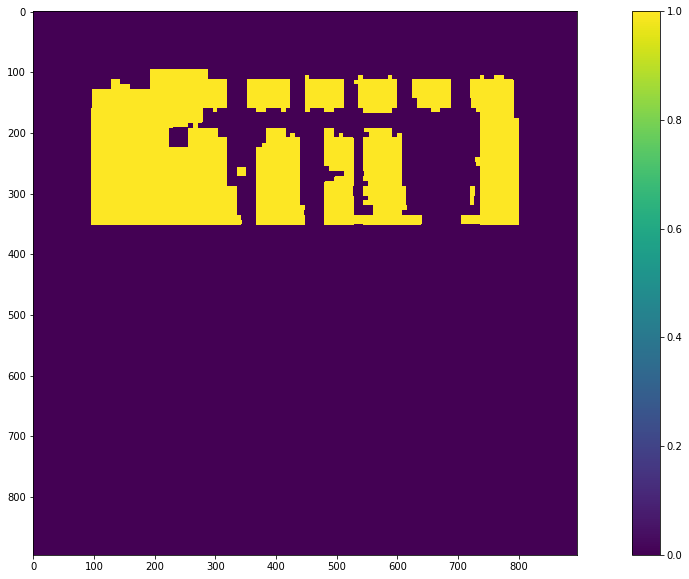

In [234]:
plt.plot()
plt.imshow(cleared, interpolation='none')
plt.colorbar(orientation='vertical')
plt.show()

In [235]:
table_height = cleared.sum(axis=0).max()

In [236]:
new_cols = []
for column in cleared.T:
    height = column.sum()
    if height / table_height < 0.5:
        new_cols.append(np.zeros_like(column))
    else:
        new_cols.append(column)

In [237]:
sep_cleared = np.stack(new_cols, axis=1)

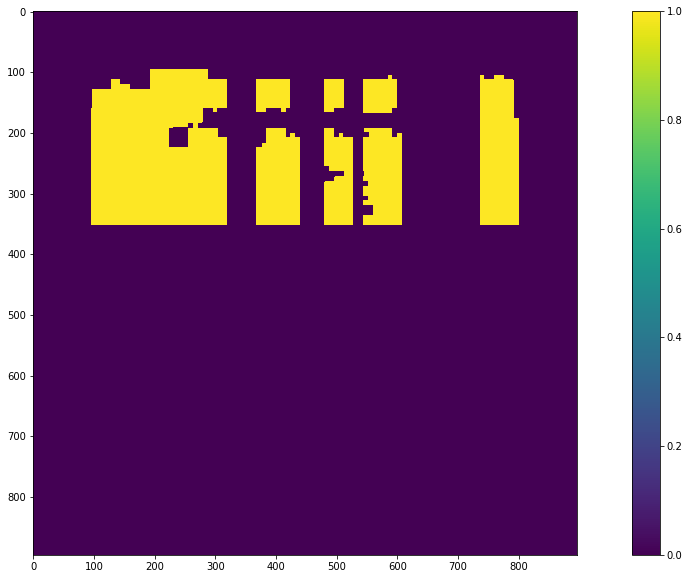

In [238]:
plt.plot()
plt.imshow(sep_cleared, interpolation='none')
plt.colorbar(orientation='vertical')
plt.show()

In [243]:
coords = np.column_stack(np.where(segmented_tables[0] > 0.5))
table_width, table_height = cv2.minAreaRect(coords)[1]

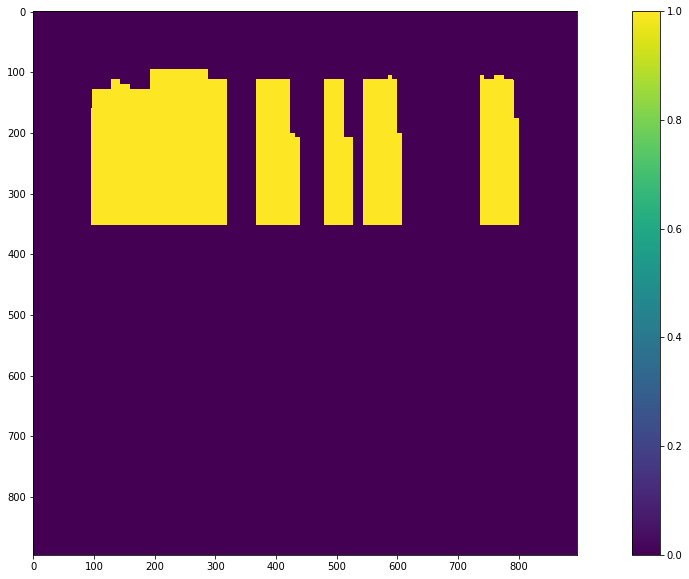

In [245]:
from skimage.morphology import rectangle
reconnected_sep_cleared = closing(sep_cleared > thresh, rectangle(int(table_height / 2), 1))

plt.plot()
plt.imshow(reconnected_sep_cleared, interpolation='none')
plt.colorbar(orientation='vertical')
plt.show()

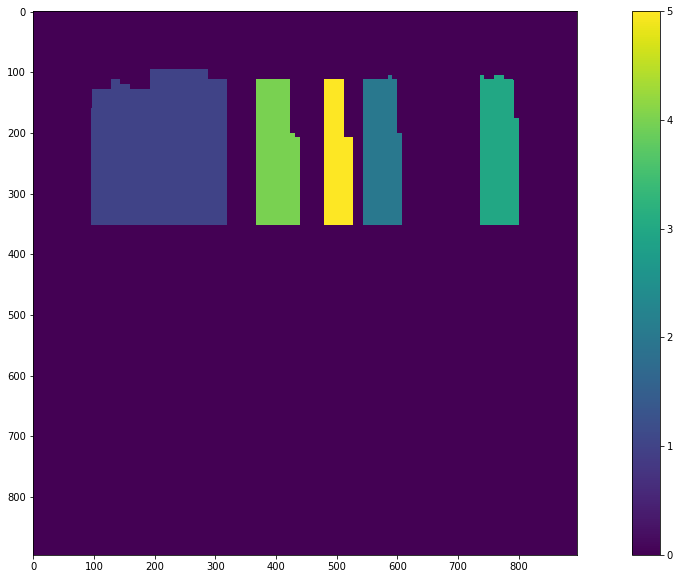

In [247]:
label_image = label(reconnected_sep_cleared)
plt.plot()
plt.imshow(label_image, interpolation='none')
plt.colorbar(orientation='vertical')
plt.show()

In [248]:
from collections import OrderedDict

cols = {}

for j in np.unique(label_image)[1:]:
    column = np.where(label_image == j, 1, 0)
    column = column.astype(int)
    if column.sum() > table_width * table_height * per:
        position = regionprops(column)[0].centroid[1]
        cols[position] = column
segmented_cols = OrderedDict(sorted(cols.items()))

In [249]:
len(segmented_cols)

5

In [250]:
from pytesseract import image_to_string, image_to_data, image_to_boxes
import pandas as pd
from skimage.morphology import binary_dilation, square

cols = []

for column in segmented_cols.values():
    width, height = image.size
    
    hull = convex_hull_image(column)
    dilation_diameter = 10 # Should be a function of the image size or of something else...?
    scaled_hull = binary_dilation(hull, square(dilation_diameter))
    
    column = resize(np.expand_dims(scaled_hull, axis=2), (height, width), preserve_range=True) > 0.01
    [rows, columns, channels] = np.where(column)
    row1 = min(rows)
    row2 = max(rows)
    col1 = min(columns)
    col2 = max(columns)
    
    crop = column * image
    white = np.ones(column.shape, dtype='uint8') * invert(column) * 255
    crop = crop + white
    cropped_image = crop[row1:row2, col1:col2]
    
    ocr_string = image_to_string(Image.fromarray(cropped_image.astype(np.uint8)), lang='fra', config='--oem 3 --psm 6')
    ocr_string_df = pd.DataFrame({"col": [value for value in ocr_string.split("\n") if len(value) > 0 and value not in ['\x0c', '', ' ']]})
    ocr_data_df = image_to_data(Image.fromarray(cropped_image.astype(np.uint8)), lang='fra', config='--oem 3 --psm 6', output_type='data.frame')
    
    tops = []
    for row in ocr_string_df.col:
        first_word = row.split(' ', 1)[0]
        index = ocr_data_df.text.eq(first_word).idxmax()
        tops.append(ocr_data_df.iloc[index].top + row1)
        ocr_data_df = ocr_data_df.iloc[index + 1:].reset_index(drop=True)
        
    ocr_string_df['top'] = tops
    if not ocr_string_df.empty:
        cols.append(ocr_string_df)

In [251]:
all_tops = np.unique(np.concatenate([df.top for df in cols]))
mean_top_diffs = [(df.top.unique()[1:] - df.top.unique()[:-1]).mean() for df in cols]
min_mean_top_diffs = min(mean_top_diffs)
threshold = min(mean_top_diffs) / 3 # HERE THIS PARAMETER MIGHT BE OPTIMIZED
for i, df in enumerate(cols):
    df['df_index'] = i
all_cols = pd.concat(cols)
all_cols = all_cols.sort_values(by='top').reset_index(drop=True)

diffs = [a - b for a, b in zip(all_cols.top.tolist(), ([0] + all_cols.top.tolist()[:-1]))]
all_cols['diffs'] = diffs
all_cols['new_line'] = np.where(all_cols.diffs > threshold, 1, 0)
all_cols['line_id'] = all_cols.new_line.cumsum()
formatted_cols = [all_cols.loc[all_cols.df_index == i] for i in range(len(cols))]
formatted_cols = [formatted_col[['col', 'line_id']].set_index('line_id') for formatted_col in formatted_cols]
formatted_cols = [formatted_col.groupby('line_id').agg({'col': ' '.join}) for formatted_col in formatted_cols]

final_df = pd.concat(formatted_cols, axis=1)

In [154]:
from pathlib import Path
path_sortie = os.path.join(dirpath + "_csv", Path(image_path).stem + "_v1.csv")

final_df.to_csv(
    path_or_buf=path_sortie, 
    index=False, 
    index_label=False
)

### Variation

In [155]:
cols = []

min_ys = []
max_ys = []
min_xs = []
max_xs = []

for column in segmented_cols.values():
    width, height = image.size
    
    hull = convex_hull_image(column)
    dilation_diameter = 10 # Should be a function of the image size or of something else...?
    scaled_hull = binary_dilation(hull, square(dilation_diameter))
    
    column = resize(np.expand_dims(scaled_hull, axis=2), (height, width), preserve_range=True) > 0.01
    [rows, columns, channels] = np.where(column)
    min_ys.append(min(rows))
    max_ys.append(max(rows))
    min_xs.append(min(columns))
    max_xs.append(max(columns))

min_y = min(min_ys)
max_y = max(max_ys)
    
for index in range(len(min_ys)):
    if index != 0:
        min_x = int((min_xs[index] + max_xs[index - 1]) / 2)
    else:
        min_x = min_xs[index]
        
    if index != len(min_ys) - 1:
        max_x = int((max_xs[index] + min_xs[index + 1]) / 2)
    else:
        max_x = max_xs[index]
    
    cropped_image = np.array(image)[min_y: max_y, min_x: max_x]

    ocr_string = image_to_string(Image.fromarray(cropped_image.astype(np.uint8)), lang='fra', config='--oem 3 --psm 6')
    ocr_string_df = pd.DataFrame({"col": [value for value in ocr_string.split("\n") if len(value) > 0 and value not in ['\x0c', '', ' ']]})
    ocr_data_df = image_to_data(Image.fromarray(cropped_image.astype(np.uint8)), lang='fra', config='--oem 3 --psm 6', output_type='data.frame')
    
    tops = []
    for row in ocr_string_df.col:
        first_word = row.split(' ', 1)[0]
        index = ocr_data_df.text.eq(first_word).idxmax()
        tops.append(ocr_data_df.iloc[index].top + row1)
        ocr_data_df = ocr_data_df.iloc[index + 1:].reset_index(drop=True)
        
    ocr_string_df['top'] = tops
    if not ocr_string_df.empty:
        cols.append(ocr_string_df)

In [156]:
all_tops = np.unique(np.concatenate([df.top for df in cols]))
mean_top_diffs = [(df.top.unique()[1:] - df.top.unique()[:-1]).mean() for df in cols]
min_mean_top_diffs = min(mean_top_diffs)
threshold = min(mean_top_diffs) / 3 # HERE THIS PARAMETER MIGHT BE OPTIMIZED
for i, df in enumerate(cols):
    df['df_index'] = i
all_cols = pd.concat(cols)
all_cols = all_cols.sort_values(by='top').reset_index(drop=True)

diffs = [a - b for a, b in zip(all_cols.top.tolist(), ([0] + all_cols.top.tolist()[:-1]))]
all_cols['diffs'] = diffs
all_cols['new_line'] = np.where(all_cols.diffs > threshold, 1, 0)
all_cols['line_id'] = all_cols.new_line.cumsum()
formatted_cols = [all_cols.loc[all_cols.df_index == i] for i in range(len(cols))]
formatted_cols = [formatted_col[['col', 'line_id']].set_index('line_id') for formatted_col in formatted_cols]
formatted_cols = [formatted_col.groupby('line_id').agg({'col': ' '.join}) for formatted_col in formatted_cols]

final_df = pd.concat(formatted_cols, axis=1)

C:\Users\RLMNGZ\AppData\Local\Temp/ipykernel_36700/957958713.py:2: RuntimeWarning: Mean of empty slice.
  mean_top_diffs = [(df.top.unique()[1:] - df.top.unique()[:-1]).mean() for df in cols]
Y:\Logiciels\Python\environnements\specifique\conda_specifique_py38_20211008\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [157]:
path_sortie = os.path.join(dirpath + "_csv", Path(image_path).stem + "_v2.csv")

final_df.to_csv(
    path_or_buf=path_sortie, 
    index=False, 
    index_label=False
)